# SPAM detection with NLP processing

The project is to build a model able to dectect wether an SMS is an spam or not. To do so we will first treat the SMS with **NLP mehtod**. 

Then we will try to apply an **classification model** on the treated SMS



### package import

In [740]:
import pandas as pd
import spacy
import re
from unidecode import unidecode
import string
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix , classification_report
import nltk
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
nltk.download('stopwords')
from nltk.corpus import stopwords

#change the working directory if necessary
df_eng=pd.read_csv(r'C:\Users\UTILISATEUR\Desktop\Spam\Spam_dataset.csv',sep=';')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\UTILISATEUR\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## **EDA** (Exploratory Data Analysis)

In [741]:
df_eng['Nature'].value_counts()

ham     4825
spam     747
Name: Nature, dtype: int64

Ham is over represented we risk that the model will overfit on the ham. We will ve carefull before trying to build a predictive model

### Cleaning the sms

In [742]:
#python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")

In [743]:
#Count upper case
df_eng['count_upper']=df_eng.SMS.apply(lambda text: len(re.findall(r'[A-Z]',text))/len(text))
print(df_eng.iloc[5370,1])
#Remove upper case
df_eng.SMS=df_eng.SMS.str.lower()
print(df_eng.iloc[5370,1])
#remove accent
df_eng.SMS=df_eng.SMS.apply(lambda text: unidecode(text))


# Replace email address with 'emailaddress'
df_eng.SMS = df_eng.SMS.apply(lambda x: re.sub(r'^.+@[^\.].*\.[a-z]{2,}$', 'emailaddress',x))
print(df_eng.iloc[5370,1])
# Replace urls with 'webaddress'
df_eng.SMS = df_eng.SMS.apply(lambda x: re.sub(r'^http?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)', 'webaddress',x))
df_eng.SMS = df_eng.SMS.apply(lambda x: re.sub(r'^https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)', 'webaddress',x))
df_eng.SMS = df_eng.SMS.apply(lambda x: re.sub(r'((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+(\.[a-zA-Z]+){1,4}', 'webaddress',x))


print(df_eng.iloc[5370,1])
# Replace money symbol with 'money-symbol'
df_eng.SMS = df_eng.SMS.apply(lambda x: re.sub(r'^(( )*\£{0,1}( )*)\d*(.\d{1,2})?$', 'moneynumb',x))
df_eng.SMS = df_eng.SMS.apply(lambda x: re.sub(r'PS\d+(,\d+)?' , 'moneynumb',x))
df_eng.SMS = df_eng.SMS.apply(lambda x: re.sub(r'\d+(,\d+)?p' , 'moneynumb',x))
df_eng.SMS = df_eng.SMS.apply(lambda x: re.sub(r'\d+(,\d+)?ppm' , 'moneynumb',x))

#replace hours
df_eng.SMS = df_eng.SMS.apply(lambda x: re.sub(r'\d+(,\d+)?(am|pm)' , 'hour',x))


print(df_eng.iloc[5370,1])
#replace numbers
df_eng.SMS=df_eng.SMS.apply(lambda x: re.sub(r'\d{10,15}','phonenumber',x))
df_eng.SMS=df_eng.SMS.apply(lambda x: re.sub(r'\d+','number',x))
print(df_eng.iloc[5370,1])


#retirer la ponctuation
df_eng.SMS=df_eng.SMS.apply(lambda text: text.translate(str.maketrans(string.punctuation ,' '*len(string.punctuation ))
                                                             ).replace(' '*4,' ').replace(' '*3,' ').replace(' '*2,' ').strip())

dating:i have had two of these. Only started after i sent a text to talk sport radio last week. Any connection do you think or coincidence?
dating:i have had two of these. only started after i sent a text to talk sport radio last week. any connection do you think or coincidence?
dating:i have had two of these. only started after i sent a text to talk sport radio last week. any connection do you think or coincidence?
dating:i have had two of these. only started after i sent a text to talk sport radio last week. any connection do you think or coincidence?
dating:i have had two of these. only started after i sent a text to talk sport radio last week. any connection do you think or coincidence?
dating:i have had two of these. only started after i sent a text to talk sport radio last week. any connection do you think or coincidence?


### Lemmatize the sms

In [744]:
#Function to lemmatize the text and take out some ponctuation and the names of peoples
def lemmatize(text):
    lemmatized_array=[]
    doc=nlp(u'{}'.format(text))
    for token in doc:
        if token.lemma_ not in ("'",",","[","]") and (not token.ent_type_ == "PER"):
            lemmatized_array.append(token.lemma_)
    return lemmatized_array

In [745]:
df_nlp_eng=df_eng.copy()

In [746]:
df_nlp_eng.SMS=df_nlp_eng.SMS.apply(lambda x: lemmatize(x))

### Stopwords treatment

In [747]:
stopWords = set(stopwords.words('english'))
stopWords.update(('nt','pl','c'))
def remove_sw(text):
    return[w for w in text if w not in stopWords]

In [748]:
df_nlp_eng.SMS=df_nlp_eng.SMS.apply(lambda text: remove_sw(text))

### Word cloud

In [749]:
df_cloud=df_nlp_eng.copy()

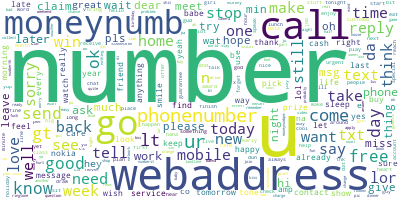

In [750]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
df_cloud.SMS=df_cloud.SMS.apply(lambda x: ' '.join(x))
long_string = ','.join(list(df_cloud.SMS.values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue',collocations=False)
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

##### Word cloud of spams and non spam

In [751]:
df_cloud_ham=df_nlp_eng[df_nlp_eng['Nature']=='ham']
df_cloud_spam=df_nlp_eng[df_nlp_eng['Nature']=='spam']

c:\Users\UTILISATEUR\anaconda3\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


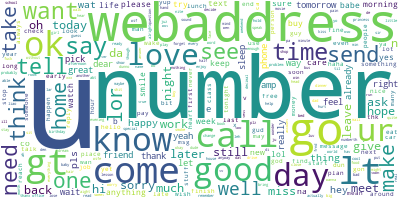

In [752]:
df_cloud_ham.SMS=df_cloud_ham.SMS.apply(lambda x: ' '.join(x))
long_string = ','.join(list(df_cloud_ham.SMS.values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue',collocations=False)
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

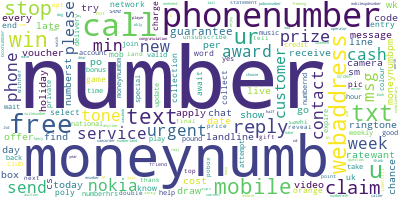

In [753]:
df_cloud_spam.SMS=df_cloud_spam.SMS.apply(lambda x: ' '.join(x))
long_string = ','.join(list(df_cloud_spam.SMS.values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue',collocations=False)
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

## Predictive model

#### Downsampling the data

In [754]:
# check percentage of data - states how much data needs to be balanced
print(str(round(747/4825,2))+'%')

0.15%


In [755]:
#clear empty fields
df_nlp_eng=df_nlp_eng[df_nlp_eng['SMS'].map(len)>0]

#we separe the two type of data
df_ham=df_nlp_eng[df_nlp_eng['Nature']=='ham']
df_spam=df_nlp_eng[df_nlp_eng['Nature']=='spam']


df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

# get the balanced dataset
df_model= pd.concat([df_spam , df_ham_downsampled])

In [756]:
#Change the categorical variable to numerical one
df_model['is_spam']=df_model['Nature'].apply(lambda x: 1 if x=='spam'else 0)

#### Compute the TF-IDF score

In [757]:
#Join the list of word to apply the tf_idf
df_model.SMS=df_model.SMS.apply(lambda x: ' '.join(x))
vectorizer=TfidfVectorizer()
X=vectorizer.fit_transform(df_model.SMS)

In [758]:
#Convert the result to a dataframe and reset the index to the right one
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
tfidf_df.set_index(df_model.index,inplace=True)

In [759]:
#Concatenate the score of tf-idf and the initial dataframe
df_model=pd.concat([df_model , tfidf_df],axis=1)

#### Random Forest Classifier Reg

In [760]:
#Separate the training set in differents one
X_model=df_model[df_model.columns.difference(['Nature', 'SMS','is_spam'])]
y=df_model[['is_spam']]
X_train, X_test, y_train, y_test = train_test_split( X_model, y, test_size=0.33, random_state=42)


#Train model
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)

<ipython-input-760-936c8b35ea25>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)


In [761]:
df_=(df_model.merge(X_test, left_index=True,right_index=True ,how='inner')).merge(pd.DataFrame({'pred':list(y_pred),'index': X_test.index}).set_index('index'),left_index=True,right_on='index')


In [762]:
for i in df_[df_['is_spam']!=df_['pred']].index:
    print(df_.loc[i,'SMS'])

sm ac sptv new jersey devil detroit red wing play ice hockey correct incorrect end reply end sptv
unique enough find numberth august webaddress
sm ac blind date numberu roddsnumber number aberdeen united kingdom check http img sm ac w icmbnumbercktznumberrnumber number blind date send hide
number date service cal l phonenumber boxnumbersknumberch
important customer service announcement premier
reminder download content already pay goto http doit mymoby tv collect content
someone conacte date service enter phone fancy find call landline phonenumber poboxnumbernnumbertfnumber
would like see xxx pic hot nearly ban uk
sexy single wait text age follow gender wither f webaddress numberf gay man text age follow g webaddress numberg
hi ya babe x u numbergoten bout I scammer get webaddress regular vodafone respond get prem rate msg subscription nos use also beware
webaddress game thedailydraw dear helen dozen free game great prizeswith
guess I first time I create web page webaddress read I writ

In [763]:
df_[df_['is_spam']!=df_['pred']]

,Nature,SMS,count_upper_x,is_spam,aah_x,ab_x,aberdeen_x,abi_x,abiola_x,able_x,...,yr_y,yrs_y,yun_y,yup_y,ze_y,zealand_y,zebra_y,zoe_y,zouk_y,pred
index,,,,,,,,,,,,,,,,,,,,,
54,spam,sm ac sptv new jersey devil detroit red wing p...,0.200000,1,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
191,spam,unique enough find numberth august webaddress,0.041667,1,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
305,spam,sm ac blind date numberu roddsnumber number ab...,0.130137,1,0.0,0.000000,0.226524,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
415,spam,number date service cal l phonenumber boxnumbe...,0.000000,1,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
752,spam,important customer service announcement premier,0.123077,1,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
881,spam,reminder download content already pay goto htt...,0.023622,1,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1745,spam,someone conacte date service enter phone fancy...,0.025806,1,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1875,spam,would like see xxx pic hot nearly ban uk,0.047619,1,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2071,spam,sexy single wait text age follow gender wither...,0.154362,1,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


#### Visualisation error

Text(105.0, 0.5, 'Actual')

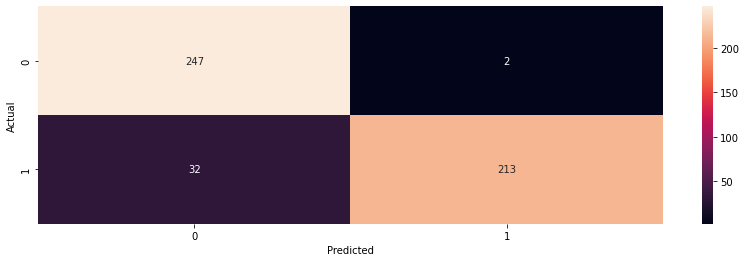

In [764]:
cm = confusion_matrix(y_test,y_pred)
# creating a graph out of confusion matrix
sns.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Actual')

#### Model on the whole dataset

In [765]:
df_test=df_nlp_eng.copy()

In [766]:
#Join the list of word to apply the tf_idf
df_test.SMS=df_test.SMS.apply(lambda x: ' '.join(x))
vectorizer=TfidfVectorizer()
X=vectorizer.fit_transform(df_test.SMS)

In [767]:
#Convert the result to a dataframe and reset the index to the right one
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
tfidf_df.set_index(df_test.index,inplace=True)

In [768]:
#Concatenate the score of tf-idf and the initial dataframe
df_test=pd.concat([df_test , tfidf_df],axis=1)

Text(105.0, 0.5, 'Actual')

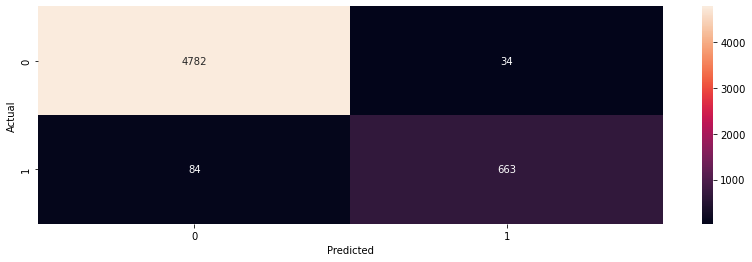

In [769]:
df_test['is_spam']=df_test['Nature'].apply(lambda x: 1 if x=='spam'else 0)


X=df_test[df_test.columns.difference(['Nature', 'SMS','is_spam'])]
X=X[X_model.columns]
y=df_test[['is_spam']]
y_pred=clf.predict(X)
cm = confusion_matrix(y,y_pred)

# creating a graph out of confusion matrix
sns.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Actual')

## N-GRAMS

For the N-gram we will use the sentences that are pre-proceced(lemmatize and cleaned of stopword)s

#### Visualization of bi-grams

In [770]:
df_gram=df_nlp_eng.copy()
df_gram['is_spam']=df_gram['Nature'].apply(lambda x: 1 if x=='spam'else 0)

In [771]:
#Fond all the bigram in the texts
def get_grams(data):

    bigrams_final=[]
    bigrams_values=0
    bigrams_labels=0
    for bigram in data.SMS:
        for i in range(0,len(bigram)-1):
            bigram_list_basic=bigram[i]+" "+bigram[i+1]
            bigrams_final.append(bigram_list_basic)

                
    bigrams_final = pd.DataFrame(bigrams_final) 
    bigrams_final.columns=["bigrams"]
    bigrams_values=bigrams_final.groupby("bigrams")["bigrams"].count()
    bigrams_labels=bigrams_final.groupby("bigrams").groups.keys()
    bigrams_final_result = pd.DataFrame(
    {
        "bigram":[*bigrams_labels],
        "count":bigrams_values
    }
    )
    return bigrams_final_result

In [772]:
df_bigram1=get_grams(df_gram[df_gram['is_spam']==1])
df_bigram2=get_grams(df_gram[df_gram['is_spam']==0])

In [773]:
def plot_grams(df_bigram,gram_n,height=4, width=14):
    bigrams_final = df_bigram
    bigrams_final = bigrams_final.sort_values("count",ascending=False).iloc[:15]
    plt.barh(bigrams_final["bigram"],bigrams_final["count"], align="center", alpha=0.7)
    plt.xlabel('Count')
    plt.title('Most common bigrams')
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = width
    fig_size[1] = height
    plt.show()
    plt.rcParams["figure.figsize"] = fig_size

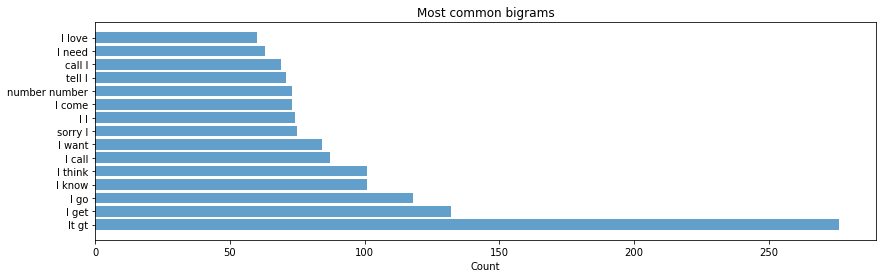

In [774]:
plot_grams(df_bigram2, gram_n=2)

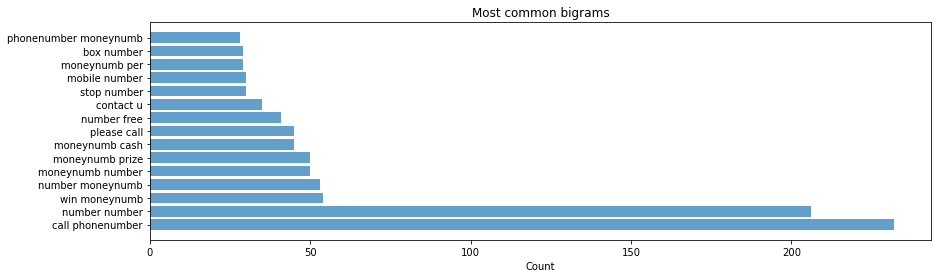

In [775]:
plot_grams(df_bigram1, gram_n=2)

In [776]:
#clear empty fields
df_gram=df_gram[df_gram['SMS'].map(len)>0]

#we separe the two type of data
df_gham=df_gram[df_gram['Nature']=='ham']
df_gspam=df_gram[df_gram['Nature']=='spam']


df_gham_downsampled = df_gham.sample(df_gspam.shape[0])
df_gham_downsampled.shape

# get the balanced dataset
df_model_gram= pd.concat([df_gspam , df_gham_downsampled])

In [777]:
# Getting bigrams 
df_model_gram.SMS=df_model_gram.SMS.apply(lambda x: ' '.join(x))
vectorizer = CountVectorizer(ngram_range =(2, 2))
X1 = vectorizer.fit_transform(df_model_gram.SMS) 
features = (vectorizer.get_feature_names())
print("\n\nX1 : \n", X1.toarray())



X1 : 
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


#### TF-IDF

In [778]:

# Applying TFIDF
# You can still get n-grams here
vectorizer = TfidfVectorizer(ngram_range = (2, 2))
X2 = vectorizer.fit_transform(df_model_gram.SMS)
scores = (X2.toarray())
print("\n\nScores : \n", scores)
  
# Getting top ranking features
sums = X2.sum(axis = 0)
data1 = []
for col, term in enumerate(features):
    data1.append( (term, sums[0, col] ))
ranking = pd.DataFrame(data1, columns = ['term', 'rank'])
words = (ranking.sort_values('rank', ascending = False))
print ("\n\nWords : \n", words.head(20))



Scores : 
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Words : 
                        term       rank
5411          number number  28.997643
872        call phonenumber  27.966237
9417          win moneynumb   9.639255
6345            please call   9.592407
4723        moneynumb prize   9.422725
5380       number moneynumb   8.166378
4677         moneynumb cash   8.130467
4218                  lt gt   7.708250
4711       moneynumb number   7.310435
5291            number free   7.272443
859              call later   7.000343
1560       customer service   6.159400
4619          mobile number   6.025799
5576      number webaddress   5.833061
7577             sorry call   5.580479
4716          moneynumb per   5.215398
8541            try contact   5.183895
3072         guarantee call   5.169247
6185  phonenumber moneynumb   5.163078
7772            stop number   5.151244


In [779]:
#Convert the result to a dataframe and reset the index to the right one
tfidf_df_gram = pd.DataFrame(scores, columns=vectorizer.get_feature_names())
tfidf_df_gram.set_index(df_model_gram.index,inplace=True)

In [780]:
#Concatenate the score of tf-idf and the initial dataframe
df_model_gram=pd.concat([df_model_gram,tfidf_df_gram],axis=1)

In [781]:
#Separate the training set in differents one
X_model=df_model_gram[df_model_gram.columns.difference(['Nature', 'SMS','is_spam'])]
y=df_model_gram[['is_spam']]
X_train, X_test, y_train, y_test = train_test_split( X_model, y, test_size=0.33, random_state=42)


#Train model
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)

cm = confusion_matrix(y_test,y_pred)
# creating a graph out of confusion matrix
sns.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Actual')

<ipython-input-781-afc14a831fa0>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)


Text(105.0, 0.5, 'Actual')

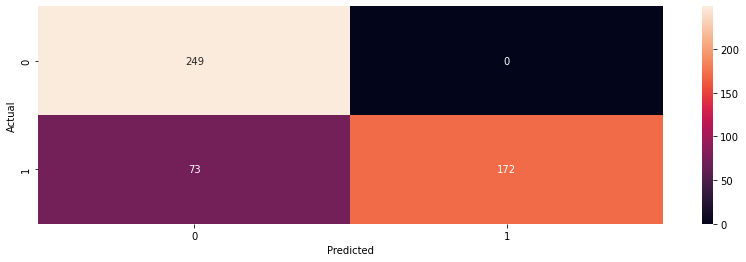

In [782]:
cm = confusion_matrix(y_test,y_pred)
# creating a graph out of confusion matrix
sns.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Actual')

#### Combination bi-gram and tf-idf

In [786]:
vectorizer=TfidfVectorizer()
X=vectorizer.fit_transform(df_model_gram.SMS)

#Convert the result to a dataframe and reset the index to the right one
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
tfidf_df.set_index(df_model.index,inplace=True)

#Concatenate the score of tf-idf and the initial dataframe
df_model=df_model_gram.merge( tfidf_df,left_index=True, right_index=True)

<ipython-input-788-9f9f79e96d14>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)


Text(105.0, 0.5, 'Actual')

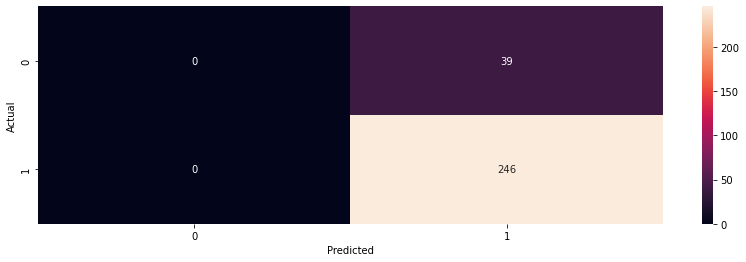

In [788]:
#Separate the training set in differents one
X_model=df_model[df_model.columns.difference(['Nature', 'SMS','is_spam'])]
y=df_model[['is_spam']]
X_train, X_test, y_train, y_test = train_test_split( X_model, y, test_size=0.33, random_state=42)


#Train model
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)

cm = confusion_matrix(y_test,y_pred)
# creating a graph out of confusion matrix
sns.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Actual')

### To develop:
* n-gram
* model to use
* TF-IDF

```

# Replace email address with 'emailaddress'
df['message'] = df['message'].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$', 'emailaddress')

# Replace urls with 'webaddress'
df['message'] = df['message'].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$', 'webaddress')

# Replace money symbol with 'money-symbol'
df['message'] = df['message'].str.replace(r'£|\$', 'money-symbol'
Can help:

```


https://dimensionless.in/spam-detection-with-natural-language-processing-part-2/

https://www.analyticsvidhya.com/blog/2021/09/performing-email-spam-detection-using-bert-in-python/
